# RNN Based Models
Bidirectional is better

The output of the Bidirectional RNN will be, by default, the concatenation of the forward layer output and the backward layer output.

In [1]:
import os
import pathlib
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
from python_speech_features import mfcc
import librosa.display
import librosa as lr
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from input_pipeline import _DATA_DIR_, _BINARIES_DIR_, _UNKNOWN_CLASS_, _SILENCE_CLASS_, _MODELS_DIR_, _TASKS_
from input_pipeline import *
from metrics import *
from custom_layers import MFCC, LogMelSpectrogram, Spectrogram
from utils import *

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2021-08-20 00:16:16.482130: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
_SMOKE_SIZE_ = -1

In [3]:
current_task = _TASKS_[2]
current_task

'35kws'

In [4]:
core_kws, aux_kws, output_classes = get_kws(_DATA_DIR_, current_task)
print("Core keywords: ", core_kws)
print()
print("Auxiliary keywords: ", aux_kws)
print()
print("Output Classes: ", output_classes)
# if the binaries for the splits are not yet generated, generate them; otherwise just load them.
if len(os.listdir(_BINARIES_DIR_/current_task)) == 0:
    #Get train, validation and test data from the splits provided in the data directory
    X_train, y_train, X_valid, y_valid, X_test, y_test = get_original_splits(current_task)
else:
    X_train, y_train, X_valid, y_valid, X_test, y_test = load_original_splits(current_task)

X_train, y_train, X_valid, y_valid, X_test, y_test = get_smoke_sized(X_train, 
                                                                     y_train, 
                                                                     X_valid, 
                                                                     y_valid, 
                                                                     X_test, 
                                                                     y_test, 
                                                                     smoke_size=_SMOKE_SIZE_)

print(f"Samples in Training Set: {len(X_train)}")
print(f"Samples in Test Set: {len(X_test)}")
print(f"Samples in Validation Set: {len(X_valid)}")

Core keywords:  ['off' 'three' 'happy' 'eight' 'up' 'no' 'seven' 'marvin' 'five' 'cat'
 'visual' 'forward' 'right' 'wow' 'zero' 'learn' 'bird' 'left' 'nine'
 'house' 'dog' 'backward' 'on' 'two' 'sheila' 'follow' 'tree' 'yes' 'four'
 'one' 'stop' 'six' 'down' 'go' 'bed']

Auxiliary keywords:  []

Output Classes:  ['off' 'three' 'happy' 'eight' 'up' 'no' 'seven' 'marvin' 'five' 'cat'
 'visual' 'forward' 'right' 'wow' 'zero' 'learn' 'bird' 'left' 'nine'
 'house' 'dog' 'backward' 'on' 'two' 'sheila' 'follow' 'tree' 'yes' 'four'
 'one' 'stop' 'six' 'down' 'go' 'bed']
Samples in Training Set: 94824
Samples in Test Set: 9981
Samples in Validation Set: 11005


In [9]:
batch_size = 128
train_dataset, train_steps, valid_dataset, valid_steps, test_dataset, test_steps = get_tf_datasets(X_train, 
                             y_train, 
                             X_valid, 
                             y_valid, 
                             X_test, 
                             y_test, 
                             batch_size=batch_size)

Train steps: 741
Validations steps: 86
Test steps: 78
Example of dataset element:
(<tf.Tensor: shape=(128, 16000), dtype=float32, numpy=
array([[ 0.00191807,  0.00046856, -0.00061515, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.0617831 ,  0.00645152,  0.02644991, ...,  0.        ,
         0.        ,  0.        ],
       [-0.04102903, -0.00264544, -0.01184857, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.02955288,
         0.01607001, -0.01702857],
       [ 0.        ,  0.        ,  0.        , ..., -0.01007987,
         0.00121587,  0.009243  ],
       [ 0.0845976 ,  0.03098951,  0.02221137, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)>, <tf.Tensor: shape=(128,), dtype=int64, numpy=
array([23, 32,  5, 26, 29, 25, 30,  8, 22, 22, 31, 14, 19, 21, 17, 13, 19,
       18, 14, 22, 23, 19, 25, 17, 25,  3, 34, 17,  1,  5, 19,  5, 17, 31,
        4, 22, 15, 34, 17, 12, 18, 31

2021-08-20 00:16:52.766804: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [10]:
def perturbate(x):
    return (x + tf.random.uniform([1],minval=-2,maxval=2.))[0]

In [11]:
x = tf.constant([1.,1.,1.,1.,1.,1.,1.])
dd = tf.data.Dataset.from_tensor_slices(x)
dd =  dd.map(perturbate)

2021-08-20 00:16:55.983197: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [12]:
for index,i in enumerate(dd.take(20)):
    print(index, i)
    

0 tf.Tensor(2.3418365, shape=(), dtype=float32)
1 tf.Tensor(0.855999, shape=(), dtype=float32)
2 tf.Tensor(2.8108134, shape=(), dtype=float32)
3 tf.Tensor(0.4647236, shape=(), dtype=float32)
4 tf.Tensor(-0.53102684, shape=(), dtype=float32)
5 tf.Tensor(0.27330685, shape=(), dtype=float32)
6 tf.Tensor(2.0889997, shape=(), dtype=float32)


## Simple RNN

In [13]:
def simple_rnn(ds, 
               output_classes, 
               n_mfcc, 
               mfcc_deltas, 
               fft_size=512, 
               win_size=400, 
               hop_size=160, 
               n_filters=40):
    
    for s, _ in ds.take(1):
        input_shape = s.shape[1:]
        print('Input shape:', input_shape)

    X_input = tf.keras.Input(input_shape)
    X = MFCC(sample_rate = 16000, 
             fft_size=fft_size, 
             win_size=win_size, 
             hop_size=hop_size, 
             n_filters=n_filters, 
             n_cepstral=n_mfcc,
            return_deltas=mfcc_deltas)(X_input)
    X = layers.BatchNormalization(axis=-1)(X)
    
    X = layers.Lambda(lambda w: tf.keras.backend.squeeze(w, -1))(X)
    X = layers.Bidirectional(layers.GRU(units=128))(X)
    X = layers.Dense(len(output_classes))(X)

    model = tf.keras.Model(inputs=X_input, outputs=X, name="SimpleRNN")
    return model

In [14]:
model_simple_rnn = simple_rnn(train_dataset, output_classes, n_mfcc=13, mfcc_deltas=True)
model_simple_rnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Input shape: (16000,)


2021-08-20 00:17:00.269530: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [15]:
model_simple_rnn.summary()

Model: "SimpleRNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16000)]           0         
_________________________________________________________________
mfcc (MFCC)                  (None, 98, 39, 1)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 39, 1)         4         
_________________________________________________________________
lambda (Lambda)              (None, 98, 39)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               129792    
_________________________________________________________________
dense (Dense)                (None, 35)                8995      
Total params: 138,791
Trainable params: 138,789
Non-trainable params: 2
___________________________________________________

In [16]:
early_stopping = tf.keras.callbacks.EarlyStopping(
            verbose=1, patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
history = model_simple_rnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)


Epoch 1/30


2021-08-20 00:17:09.364168: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2021-08-20 00:17:09.450099: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-20 00:17:09.692900: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-08-20 00:17:09.722767: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-08-20 00:17:10.001465: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100


741/741 [==============================] - ETA: 0s - loss: 1.5683 - accuracy: 0.5598

2021-08-20 00:18:29.702410: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


741/741 [==============================] - 92s 119ms/step - loss: 1.5683 - accuracy: 0.5598 - val_loss: 0.6200 - val_accuracy: 0.8127
Epoch 2/30
  2/741 [..............................] - ETA: 51s - loss: 0.6786 - accuracy: 0.8164

2021-08-20 00:18:38.201029: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


741/741 [==============================] - 44s 60ms/step - loss: 0.4858 - accuracy: 0.8599 - val_loss: 0.4210 - val_accuracy: 0.8734
Epoch 3/30
741/741 [==============================] - 42s 57ms/step - loss: 0.3573 - accuracy: 0.8964 - val_loss: 0.3665 - val_accuracy: 0.8892
Epoch 4/30
741/741 [==============================] - 44s 59ms/step - loss: 0.2939 - accuracy: 0.9146 - val_loss: 0.3399 - val_accuracy: 0.8981
Epoch 5/30
741/741 [==============================] - 44s 60ms/step - loss: 0.2498 - accuracy: 0.9268 - val_loss: 0.3299 - val_accuracy: 0.8985
Epoch 6/30
741/741 [==============================] - 46s 62ms/step - loss: 0.2153 - accuracy: 0.9372 - val_loss: 0.3284 - val_accuracy: 0.9018
Epoch 7/30
741/741 [==============================] - 47s 63ms/step - loss: 0.1919 - accuracy: 0.9450 - val_loss: 0.3232 - val_accuracy: 0.9034
Epoch 8/30
741/741 [==============================] - 45s 61ms/step - loss: 0.1699 - accuracy: 0.9510 - val_loss: 0.3299 - val_accuracy: 0.9035
Epo

In [33]:
#save model
model_simple_rnn.save(_MODELS_DIR_/current_task/(model_simple_rnn.name+'.h5'))

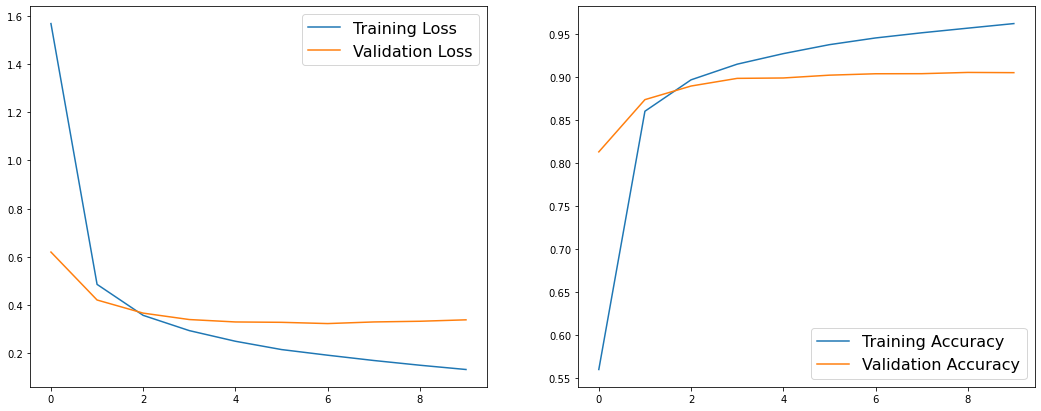

In [18]:
training_data = history.history
plt.figure(figsize=(18,7))
plt.subplot(1,2,1)
plt.plot(range(len(training_data['loss'])), training_data['loss'], label="Training Loss")
plt.plot(range(len(training_data['val_loss'])), training_data['val_loss'], label="Validation Loss")
plt.legend(fontsize=16)

plt.subplot(1,2,2)
plt.plot(range(len(training_data['accuracy'])), training_data['accuracy'], label="Training Accuracy")
plt.plot(range(len(training_data['val_accuracy'])), training_data['val_accuracy'], label="Validation Accuracy")

plt.legend(fontsize=16)
plt.show()

In [22]:
y_scores = model_simple_rnn.predict(test_dataset)
y_pred = np.array(np.argmax(y_scores, axis=1))
y_true = np.array(y_test)

Test set accuracy: 95.061%


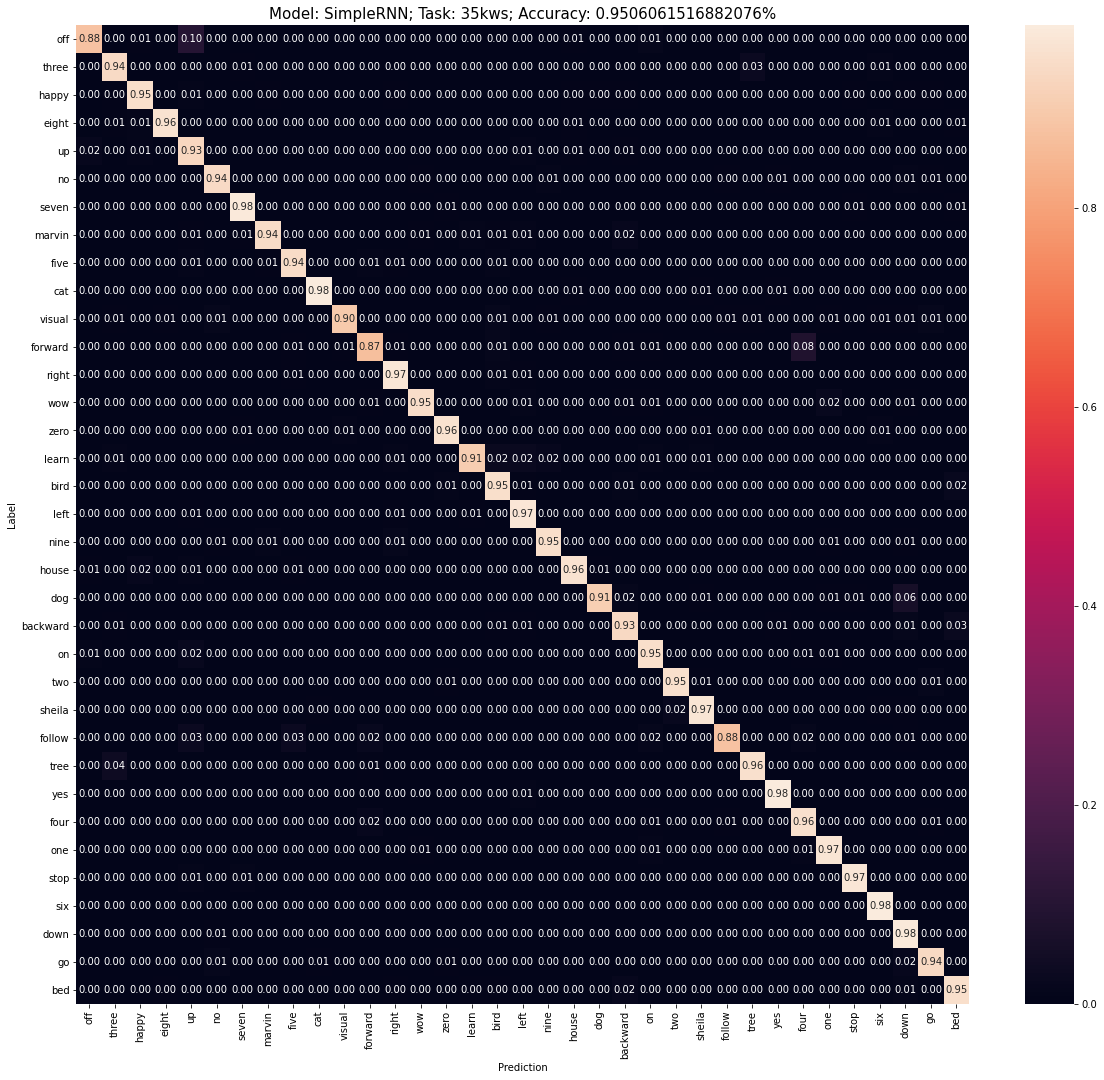

In [31]:
# compute test accuracy
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

confusion_mtx = confusion_matrix(y_true, y_pred, normalize='true') 
plt.figure(figsize=(20, 18))
sns.heatmap(confusion_mtx, xticklabels=output_classes, yticklabels=output_classes, 
            annot=True, fmt =".2f")
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title(f"Model: {model_simple_rnn.name}; Task: {current_task}; Accuracy: {test_acc}%", fontsize=15)
# plt.savefig(_MODELS_DIR_/current_task/f'{model_simple_rnn.name}.png', dpi=300)
plt.show()

## CNN + RNN

In [27]:
def cnn_rnn(ds, 
               output_classes, 
               n_mfcc, 
               mfcc_deltas, 
               fft_size=512, 
               win_size=400, 
               hop_size=160, 
               n_filters=40):
    
    for s, _ in ds.take(1):
        input_shape = s.shape[1:]
        print('Input shape:', input_shape)

    X_input = tf.keras.Input(input_shape)
    X = MFCC(sample_rate = 16000, 
             fft_size=fft_size, 
             win_size=win_size, 
             hop_size=hop_size, 
             n_filters=n_filters, 
             n_cepstral=n_mfcc,
            return_deltas=mfcc_deltas)(X_input)
    X = layers.BatchNormalization(axis=-1)(X)
    
    X = layers.Conv2D(64, (20,1))(X)
    X = layers.BatchNormalization(axis =-1)(X)
    X = layers.Activation('relu')(X)
    
    X = layers.Conv2D(1, (10,1))(X)
    X = layers.BatchNormalization(axis =-1)(X)
    X = layers.Activation('relu')(X)

    
    X = layers.Lambda(lambda w: tf.keras.backend.squeeze(w, -1))(X)
    X = layers.Bidirectional(layers.GRU(units=128))(X)
    X = layers.Dense(len(output_classes))(X)

    model = tf.keras.Model(inputs=X_input, outputs=X, name="SimpleRNN")
    return model

In [28]:
model_cnn_rnn = cnn_rnn(train_dataset, output_classes, n_mfcc=40, mfcc_deltas=False)
model_cnn_rnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model_cnn_rnn.summary()

Input shape: (16000,)
Model: "SimpleRNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 16000)]           0         
_________________________________________________________________
mfcc_2 (MFCC)                (None, 98, 40, 1)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 98, 40, 1)         4         
_________________________________________________________________
conv1 (Conv2D)               (None, 79, 40, 64)        1344      
_________________________________________________________________
bn_conv1 (BatchNormalization (None, 79, 40, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 79, 40, 64)        0         
_________________________________________________________________
conv2 (Conv2D)               (None,

In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(
            verbose=1, patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()
history = model_cnn_rnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)


Epoch 1/30
741/741 [==============================] - 42s 52ms/step - loss: 1.8095 - accuracy: 0.4870 - val_loss: 0.9009 - val_accuracy: 0.7335
Epoch 2/30
257/741 [=========>....................] - ETA: 24s - loss: 0.8238 - accuracy: 0.7598

KeyboardInterrupt: 

## Attention based RNN

In [260]:
w = generate_train_sample(X_train[0])
w = tf.expand_dims(w,0)
w = tf.concat([w,w], 0)
w

<tf.Tensor: shape=(2, 16000), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , ..., 0.00043109, 0.00045743,
        0.00094112],
       [0.        , 0.        , 0.        , ..., 0.00043109, 0.00045743,
        0.00094112]], dtype=float32)>

In [419]:
def simple_attention_rnn(ds):
    for s, _ in ds.take(1):
        input_shape = s.shape[1:]
        print('Input shape:', input_shape)

    X_input = tf.keras.Input(input_shape)
    X = MFCC(sample_rate = 16000, 
                 fft_size=512, 
                 win_size=400, 
                 hop_size=160, 
                 n_filters=40, 
                 n_cepstral=13,
                return_deltas=True)(X_input)
    X = layers.Lambda(lambda x : x[...,-1], name="squeeze_channel_dimension")(X)
    X = layers.Bidirectional(layers.GRU(units=64, return_sequences=True), name="BidirectionalGRU")(X)
    last_out = layers.Lambda(lambda x: x[:,-1,:])(X)
    Q = layers.Dense(128)(last_out)
    Q = layers.Lambda(lambda x: tf.expand_dims(x, 1))(Q)
    weighted_seq, att_ws = layers.Attention()([Q, X], return_attention_scores=True)

    O = layers.Dense(128, activation='relu')(weighted_seq)
    O = layers.Dense(64, activation='relu')(O)
    O = layers.Dense(len(output_classes), name="out_layer")(O)

    att_model = tf.keras.Model(inputs = [X_input], outputs=[O,att_ws])
    return att_model

In [420]:
att_model = simple_attention_rnn(train_dataset)
att_model.summary()

Input shape: (16000,)
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 16000)]      0                                            
__________________________________________________________________________________________________
mfcc_84 (MFCC)                  (None, 98, 39, 1)    0           input_17[0][0]                   
__________________________________________________________________________________________________
squeeze_channel_dimension (Lamb (None, 98, 39)       0           mfcc_84[0][0]                    
__________________________________________________________________________________________________
BidirectionalGRU (Bidirectional (None, 98, 128)      40320       squeeze_channel_dimension[0][0]  
______________________________________________________________________

In [422]:
# tf.keras.utils.plot_model(att_model)

In [359]:
att_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss={'out_layer':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)},
    metrics={'out_layer':'accuracy'},
)

In [360]:
early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, patience=4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3, monitor='val_accuracy', verbose=1)
history = att_model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/30


2021-08-20 03:00:54.458048: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5141626880 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


741/741 [==============================] - ETA: 0s - loss: 0.9864 - out_layer_loss: 0.9864 - out_layer_accuracy: 0.7123

2021-08-20 03:01:35.604136: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5141626880 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


741/741 [==============================] - 49s 61ms/step - loss: 0.9864 - out_layer_loss: 0.9864 - out_layer_accuracy: 0.7123 - val_loss: 0.7142 - val_out_layer_loss: 0.7142 - val_out_layer_accuracy: 0.7890
Epoch 2/30
741/741 [==============================] - 44s 59ms/step - loss: 0.5853 - out_layer_loss: 0.5853 - out_layer_accuracy: 0.8295 - val_loss: 0.5596 - val_out_layer_loss: 0.5596 - val_out_layer_accuracy: 0.8367
Epoch 3/30
741/741 [==============================] - 45s 60ms/step - loss: 0.4606 - out_layer_loss: 0.4606 - out_layer_accuracy: 0.8656 - val_loss: 0.4881 - val_out_layer_loss: 0.4881 - val_out_layer_accuracy: 0.8563
Epoch 4/30
741/741 [==============================] - 42s 57ms/step - loss: 0.3915 - out_layer_loss: 0.3915 - out_layer_accuracy: 0.8857 - val_loss: 0.4430 - val_out_layer_loss: 0.4430 - val_out_layer_accuracy: 0.8696
Epoch 5/30
741/741 [==============================] - 43s 58ms/step - loss: 0.3470 - out_layer_loss: 0.3470 - out_layer_accuracy: 0.8984 - 

In [380]:
y_scores = att_model.predict(test_dataset)
y_scores = y_scores[0][:,0,:]
y_pred = np.array(np.argmax(y_scores, axis=1))
y_true = np.array(y_test)

# compute test accuracy
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

Test set accuracy: 94.249%


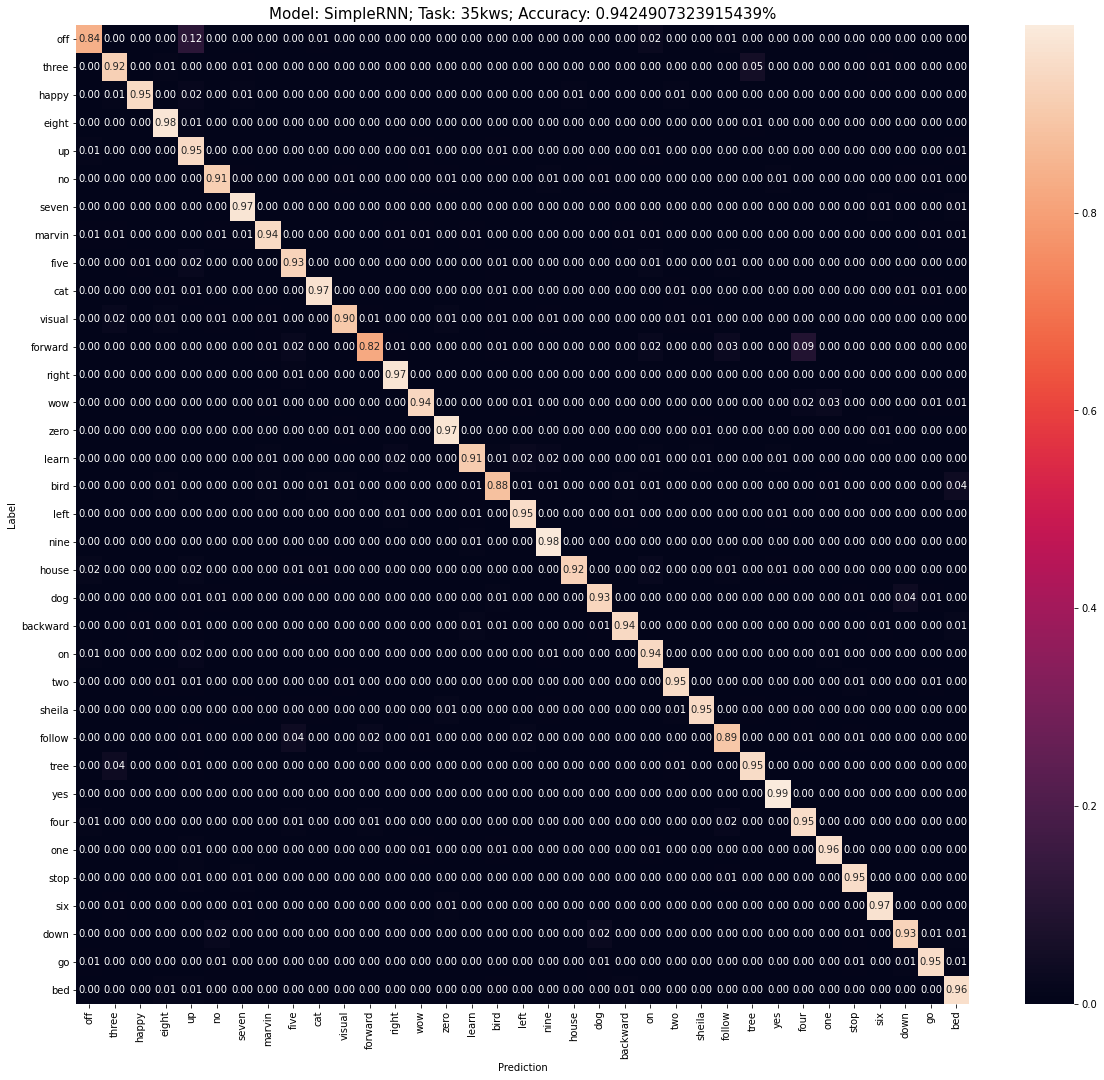

In [381]:
confusion_mtx = confusion_matrix(y_true, y_pred, normalize='true') 
plt.figure(figsize=(20, 18))
sns.heatmap(confusion_mtx, xticklabels=output_classes, yticklabels=output_classes, 
            annot=True, fmt =".2f")
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title(f"Model: {model_simple_rnn.name}; Task: {current_task}; Accuracy: {test_acc}%", fontsize=15)
# plt.savefig(_MODELS_DIR_/current_task/f'{model_simple_rnn.name}.png', dpi=300)
plt.show()

In [417]:
aaa = atts[0,0,:]
aaa = np.apply_along_axis(np.max,0,aaa)

In [418]:
aaa

array(0.95966727, dtype=float32)

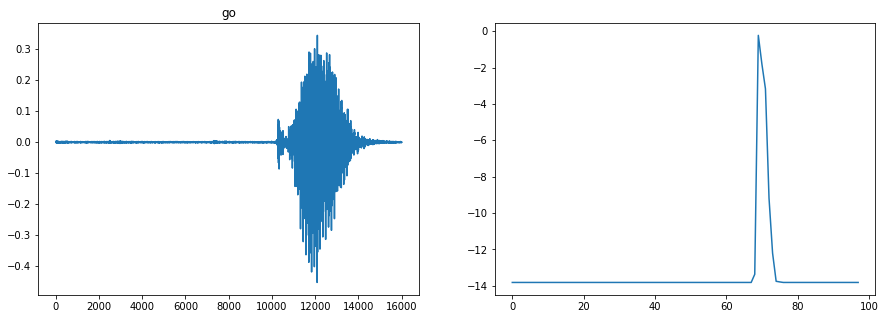

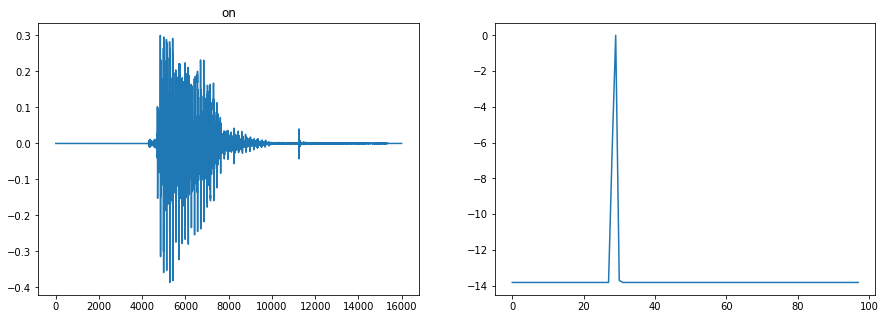

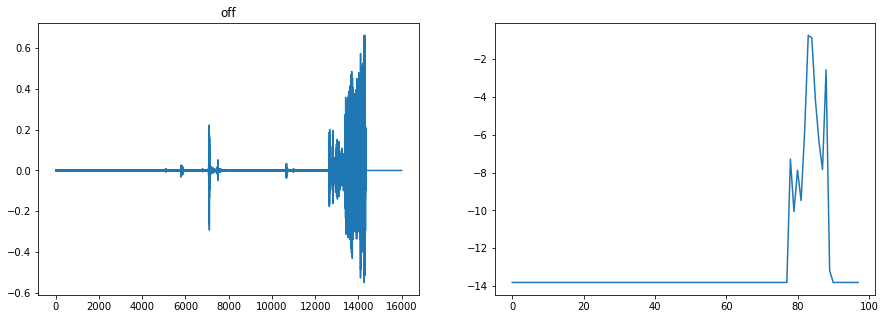

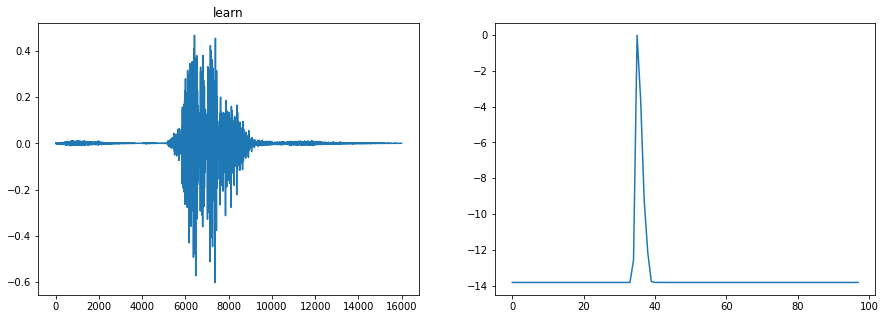

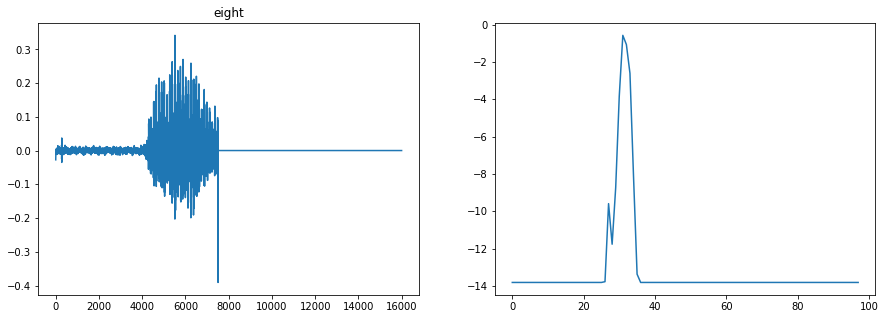

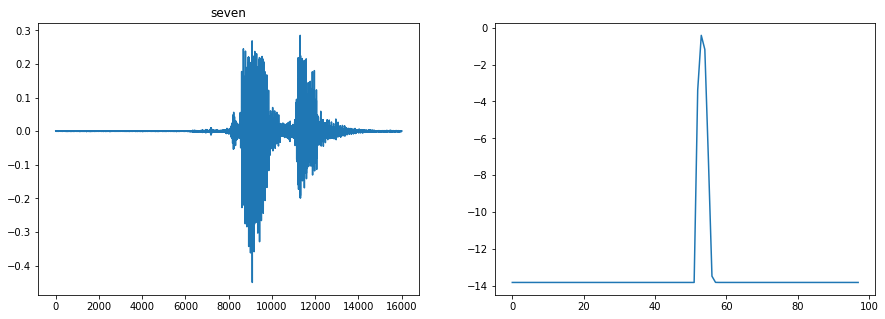

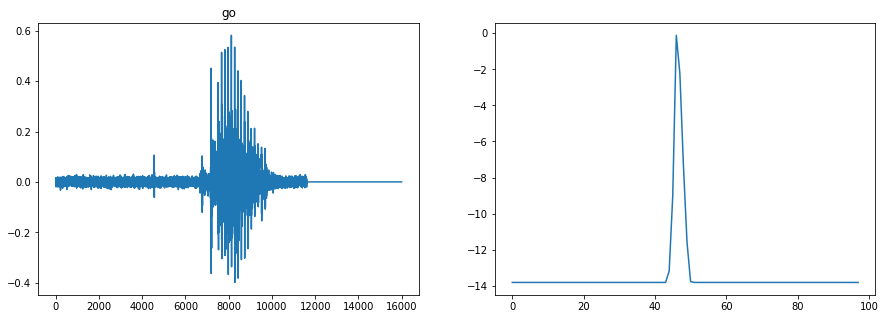

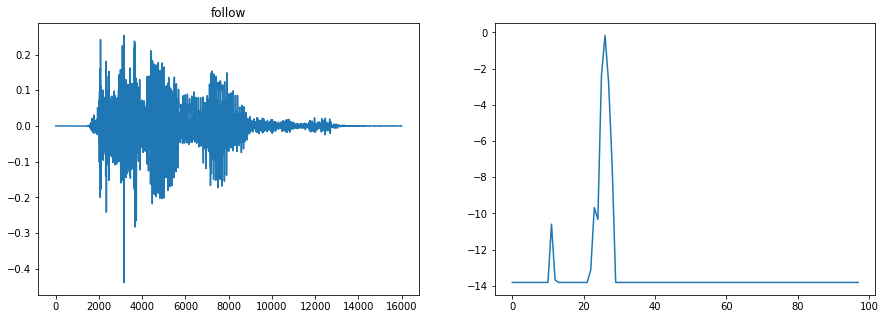

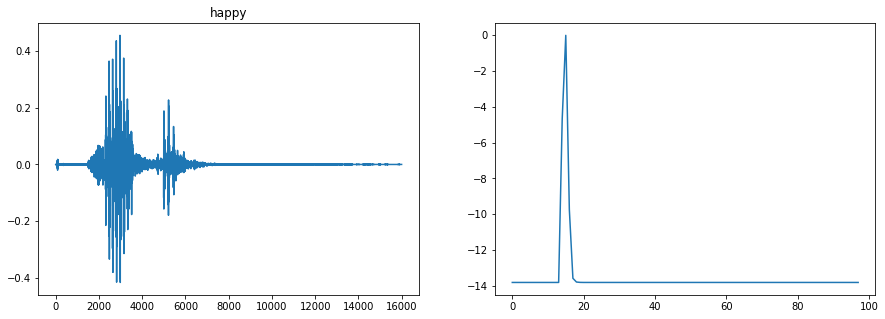

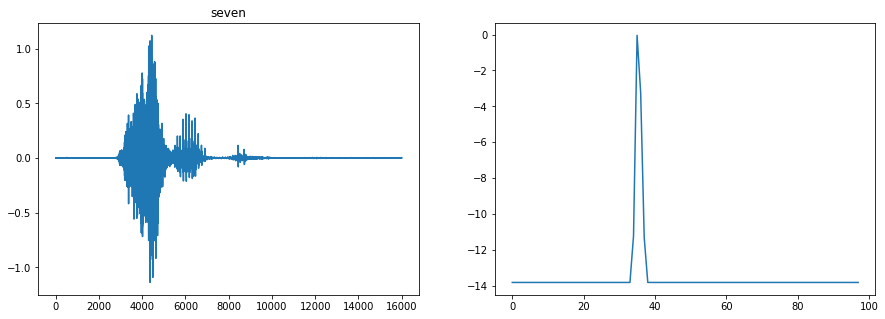

In [412]:
for i in range(10,20):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    ex = generate_test_sample(X_test[i])
    ex = tf.expand_dims(ex,0)
    plt.plot(ex[0])
    plt.title(output_classes[y_test[i]])
#     plt.show()
    plt.subplot(1,2,2)
    atts = att_model(ex)[1]
    plt.plot(np.log(atts[0,0,:] + 0.000001))
    
    plt.show()

## Attention model from paper

In [438]:
def attention_rnn_andreade(ds):
    """Neural attention model proposed in de Andreade et al. 2018"""
    for s, _ in ds.take(1):
        input_shape = s.shape[1:]
        print('Input shape:', input_shape)

    X_input = tf.keras.Input(input_shape)
    X =  LogMelSpectrogram(sample_rate = 16000, 
                 fft_size=1024, 
                 win_size=400, 
                 hop_size=160, 
                 n_filters=80)(X_input)
    X = layers.Lambda(lambda x : x[:,:,1:,:], name="remove_energies")(X)
    
    # CNN part
    X = layers.Conv2D(10, (5, 1), activation='relu', padding='same')(X)
    X = layers.BatchNormalization()(X)
    X = layers.Conv2D(1, (5, 1), activation='relu', padding='same')(X)
    X = layers.BatchNormalization()(X)
    
    # Recurrent Part
    X = layers.Lambda(lambda x : x[...,-1], name="squeeze_channel_dimension")(X)
    X = layers.Bidirectional(layers.GRU(units=64, return_sequences=True), name="BidirectionalGRU")(X)
    last_out = layers.Lambda(lambda x: x[:,-1,:])(X)
    
    # Self-Attention
    Q = layers.Dense(128)(last_out)
    Q = layers.Lambda(lambda x: tf.expand_dims(x, 1))(Q)
    weighted_seq, att_ws = layers.Attention()([Q, X], return_attention_scores=True)

    O = layers.Dense(64, activation='relu')(weighted_seq)
    O = layers.Dense(len(output_classes), name="out_layer")(O)

    att_model = tf.keras.Model(inputs = [X_input], outputs=[O,att_ws])
    return att_model

In [441]:
model_att_andreade = attention_rnn_andreade(train_dataset)
model_att_andreade.summary()

Input shape: (16000,)
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 16000)]      0                                            
__________________________________________________________________________________________________
log_mel_spectrogram_211 (LogMel (None, 98, 81, 1)    0           input_23[0][0]                   
__________________________________________________________________________________________________
remove_energies (Lambda)        (None, 98, 80, 1)    0           log_mel_spectrogram_211[0][0]    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 98, 80, 10)   60          remove_energies[0][0]            
_____________________________________________________________________

In [442]:
model_att_andreade.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss={'out_layer':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)},
    metrics={'out_layer':'accuracy'},
)

early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1, patience=4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3, monitor='val_out_layer_accuracy', verbose=1)
history =model_att_andreade.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_steps,
    validation_steps=valid_steps)

Epoch 1/30


2021-08-20 04:34:21.038552: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5141626880 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


740/741 [============================>.] - ETA: 0s - loss: 1.2910 - out_layer_loss: 1.2910 - out_layer_accuracy: 0.6425

2021-08-20 04:34:48.455110: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5141626880 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


741/741 [==============================] - 31s 39ms/step - loss: 1.2899 - out_layer_loss: 1.2899 - out_layer_accuracy: 0.6427 - val_loss: 0.6467 - val_out_layer_loss: 0.6467 - val_out_layer_accuracy: 0.8134
Epoch 2/30
741/741 [==============================] - 28s 38ms/step - loss: 0.5129 - out_layer_loss: 0.5129 - out_layer_accuracy: 0.8559 - val_loss: 0.4432 - val_out_layer_loss: 0.4432 - val_out_layer_accuracy: 0.8717
Epoch 3/30
741/741 [==============================] - 28s 38ms/step - loss: 0.3795 - out_layer_loss: 0.3795 - out_layer_accuracy: 0.8926 - val_loss: 0.3750 - val_out_layer_loss: 0.3750 - val_out_layer_accuracy: 0.8892
Epoch 4/30
741/741 [==============================] - 28s 37ms/step - loss: 0.3186 - out_layer_loss: 0.3186 - out_layer_accuracy: 0.9084 - val_loss: 0.3317 - val_out_layer_loss: 0.3317 - val_out_layer_accuracy: 0.8989
Epoch 5/30
741/741 [==============================] - 28s 38ms/step - loss: 0.2811 - out_layer_loss: 0.2811 - out_layer_accuracy: 0.9183 - 

In [443]:
y_scores = model_att_andreade.predict(test_dataset)
y_scores = y_scores[0][:,0,:]
y_pred = np.array(np.argmax(y_scores, axis=1))
y_true = np.array(y_test)

# compute test accuracy
test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.3%}')

2021-08-20 04:43:49.719912: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "GeForce GTX 1060 6GB" frequency: 1784 num_cores: 10 environment { key: "architecture" value: "6.1" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 1572864 shared_memory_size_per_multiprocessor: 98304 memory_size: 5141626880 bandwidth: 192192000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Test set accuracy: 96.453%


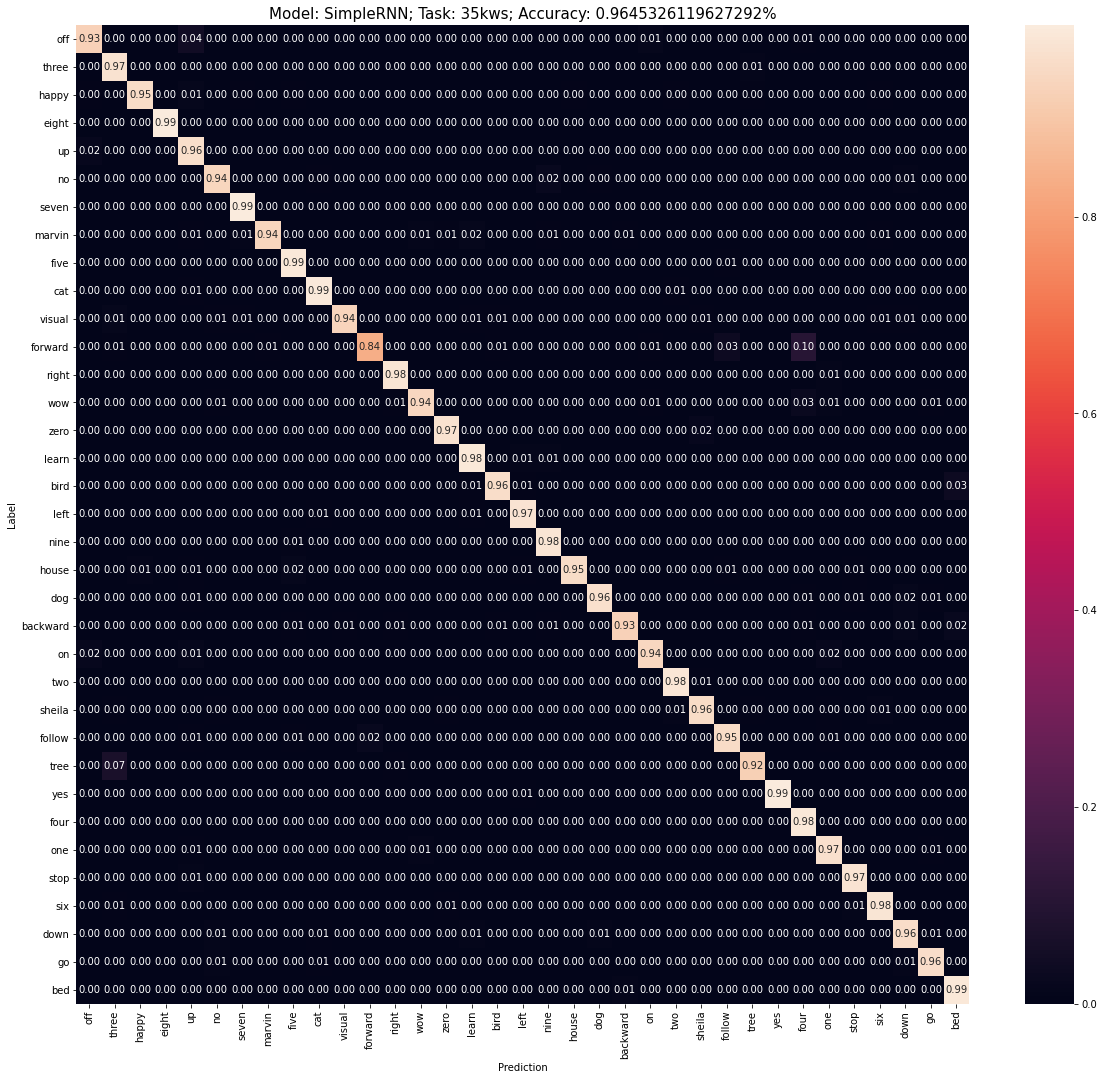

In [444]:
confusion_mtx = confusion_matrix(y_true, y_pred, normalize='true') 
plt.figure(figsize=(20, 18))
sns.heatmap(confusion_mtx, xticklabels=output_classes, yticklabels=output_classes, 
            annot=True, fmt =".2f")
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title(f"Model: {model_simple_rnn.name}; Task: {current_task}; Accuracy: {test_acc}%", fontsize=15)
# plt.savefig(_MODELS_DIR_/current_task/f'{model_simple_rnn.name}.png', dpi=300)
plt.show()

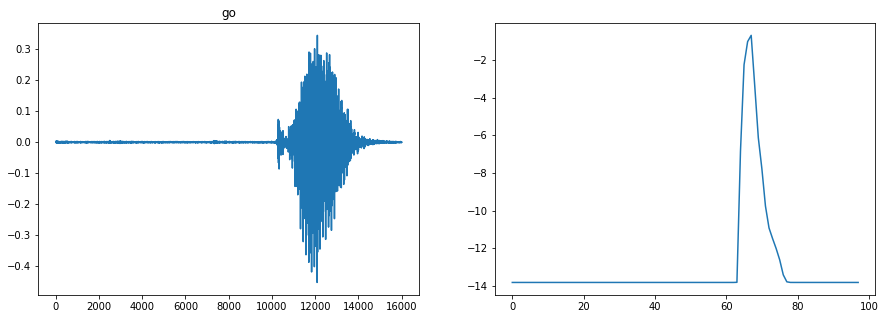

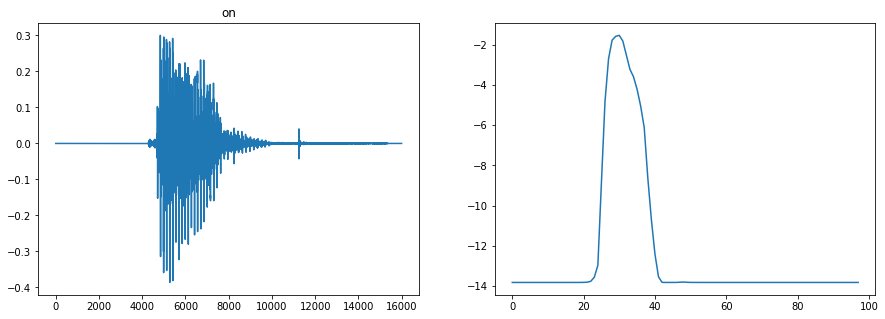

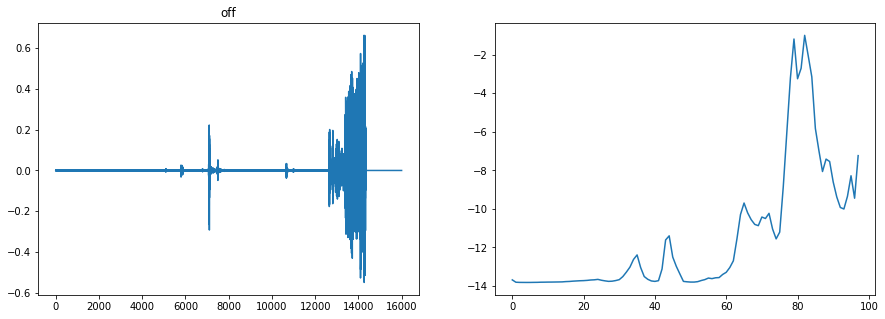

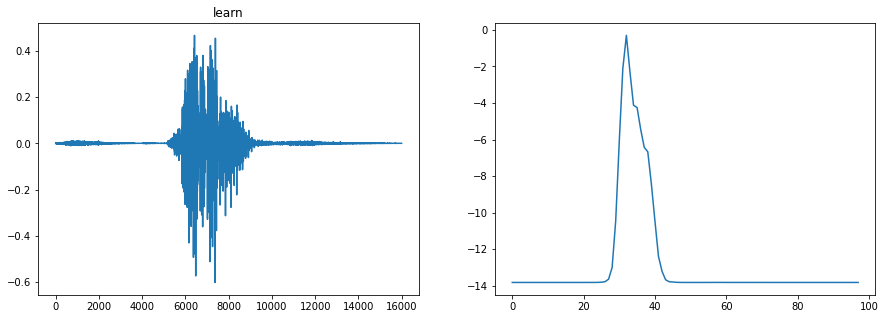

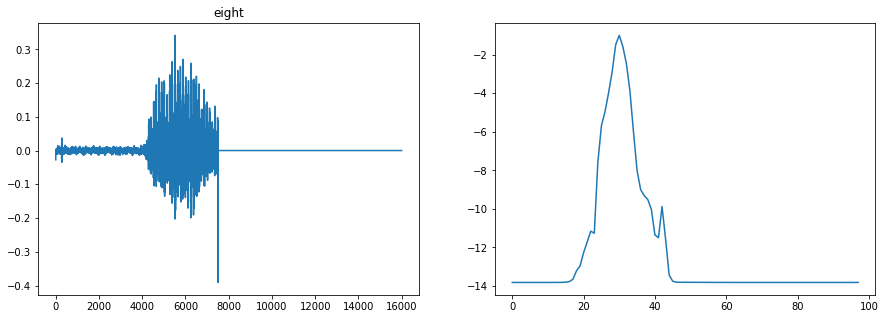

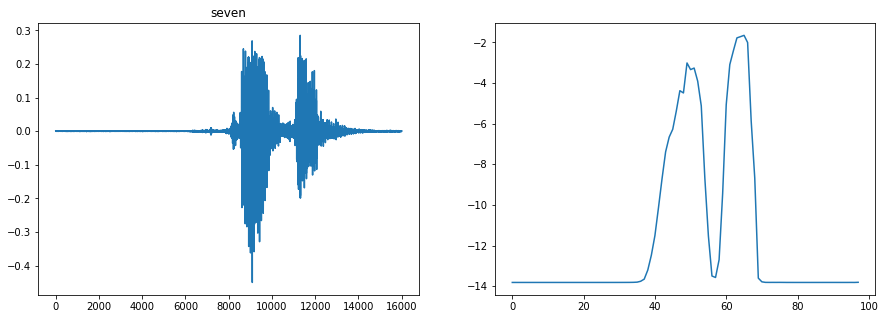

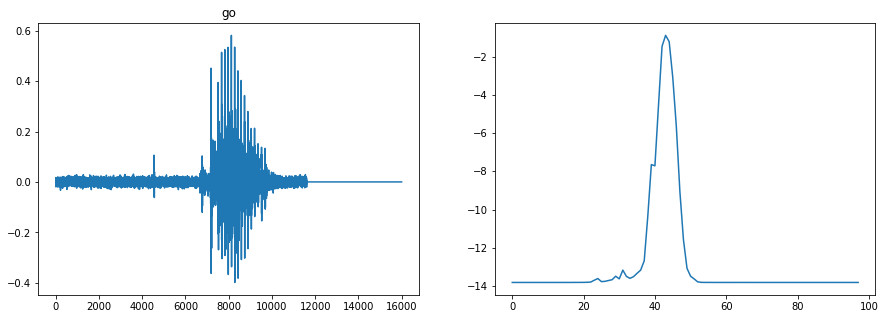

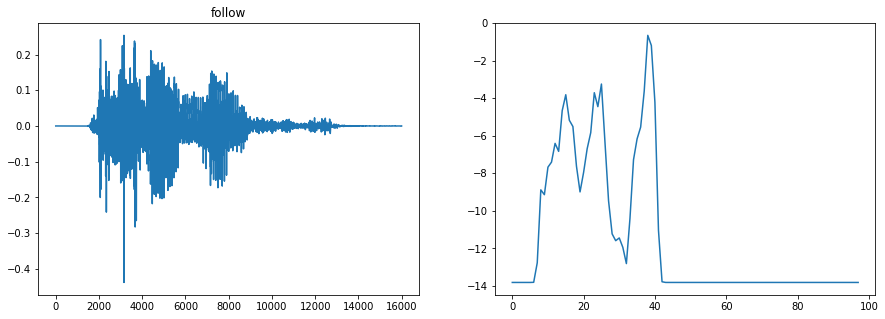

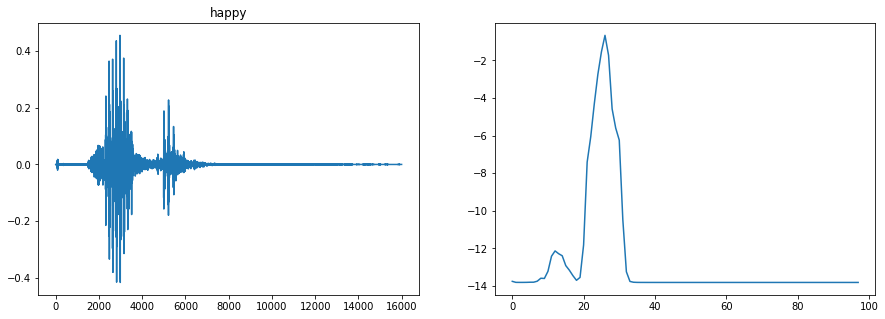

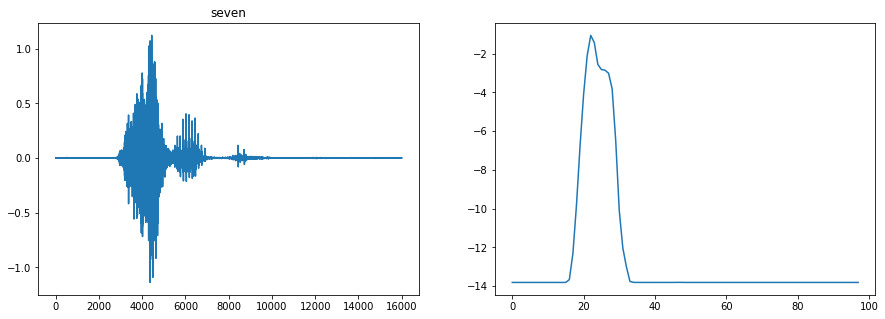

In [445]:
for i in range(10,20):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    ex = generate_test_sample(X_test[i])
    ex = tf.expand_dims(ex,0)
    plt.plot(ex[0])
    plt.title(output_classes[y_test[i]])
#     plt.show()
    plt.subplot(1,2,2)
    atts = model_att_andreade(ex)[1]
    plt.plot(np.log(atts[0,0,:] + 0.000001))
    
    plt.show()